In [1]:
import pickle
from pathlib import Path
import numpy as np
import gurobipy as gp; gp.Model()

from src.input import Input_uc, get_min_up_down_initials
from src.output import Output_uc
from src.unit_commitment import solve_uc
from src.plot import plot_schedule_heatmap

Set parameter Username
Set parameter LicenseID to value 2659802


Academic license - for non-commercial use only - expires 2026-05-01


In [2]:
def load_data():
    path_folder_processed = Path.cwd() / "data" / "input" / "processed"
    timestamp_2022 = np.load(path_folder_processed / "timestamp_2022.npy")
    
    global num_units, num_periods, time_start
    num_units = 122
    num_periods = 24
    ############### 7 21!!!!!!!!!!!!! NOT MY BDAY SO THIS FILE SHOULD BE RE RUN WHENEVER IM DOING ANOTHER DATE THAN BELOW
    time_start, time_end = np.datetime64("2022-07-21T00"), np.datetime64("2022-07-21T23")
    idx_time_start, idx_time_end = np.where(timestamp_2022 == time_start)[0][0], np.where(timestamp_2022 == time_end)[0][0]

    global unit_type, idx_nuclear, idx_coal, idx_lng
    unit_type = np.load(path_folder_processed / "unit_type.npy")
    idx_nuclear = np.load(path_folder_processed / "idx_nuclear.npy")
    idx_coal = np.load(path_folder_processed / "idx_coal.npy")
    idx_lng = np.load(path_folder_processed / "idx_lng.npy")

    global p_min, p_max, ramp_up, ramp_down, startup_ramp, shutdown_ramp, min_up, min_down
    p_min = np.load(path_folder_processed / "p_min.npy")
    p_max = np.load(path_folder_processed / "p_max.npy")
    ramp_up = np.load(path_folder_processed / "ramp_up.npy")
    ramp_down = np.load(path_folder_processed / "ramp_down.npy")
    startup_ramp = np.load(path_folder_processed / "startup_ramp.npy")
    shutdown_ramp = np.load(path_folder_processed / "shutdown_ramp.npy")
    min_up = np.load(path_folder_processed / "min_up.npy")
    min_down = np.load(path_folder_processed / "min_down.npy")

    global cost_lin, cost_const, cost_startup_step_old, num_cooling_steps_old, cost_startup_step, step_length
    cost_lin = np.load(path_folder_processed / "cost_lin.npy")
    cost_const = np.load(path_folder_processed / "cost_const.npy")
    cost_startup_step_old = pickle.load(open(path_folder_processed / "cost_startup_step_old.pkl", "rb"))
    num_cooling_steps_old = np.load(path_folder_processed / "num_cooling_steps_old.npy")
    cost_startup_step = np.load(path_folder_processed / "cost_startup_step.npy")
    step_length = np.load(path_folder_processed / "step_length.npy")

    global demand, renewable
    demand = np.load(path_folder_processed / "demand_2022.npy")[idx_time_start:idx_time_end+1]
    renewable = np.load(path_folder_processed / "renewable_gen_2022.npy")[idx_time_start:idx_time_end+1]

In [3]:
load_data()

In [4]:
def get_initial_conditions(reserve_margin_ic: float, verbose: bool):
    """
    issue:
    KPG commitment decision data reliance (which i have 0 reason to do so)
    # status_2022 = np.load(path_folder_processed / "status_2022.npy")
    # u_prev_ic = status_2022[:, idx_time_start-num_cooling_steps_old.max():idx_time_start]
    there are just too many unjustifiable modeling design / logic flaws if i use KPG renewables (data.py) not that the data itself is an issue

    solution: 
    black start -60 hours
    guaranteed steady state for initial conditions
    at t=-1 (or -48h ~ -1h) (unless some inhumane numerical stability stuffs)
    currently unsure about setting reserve margin requirement even before including NSE
    idk comment may not be fixed but code may be in future too busy rn
    """
    num_periods_ic = 60
    # pure black start prev condition
    p_prev_ic = np.zeros(num_units)
    u_prev_ic = np.zeros((num_units, num_periods_ic), dtype=np.int64)
    min_up_r_ic, min_down_r_ic, min_up_0_ic, min_down_0_ic = get_min_up_down_initials(num_units, min_up, min_down, u_prev_ic)
    
    demand_ic = np.full((num_periods_ic), demand[0])
    renewable_ic = np.full((num_periods_ic), renewable[0])
    reserve_ic = (demand_ic - renewable_ic) * reserve_margin_ic

    input_uc_ic = Input_uc(
        # meta
        unit_type=unit_type,
        idx_nuclear=idx_nuclear,
        idx_coal=idx_coal,
        idx_lng=idx_lng,
        num_units=num_units,
        num_periods=num_periods_ic,
        # system
        demand=demand_ic,
        reserve=reserve_ic,
        renewable=renewable_ic,
        # generator
        p_min=p_min,
        p_max=p_max,
        ramp_up=ramp_up,
        ramp_down=ramp_down,
        startup_ramp=startup_ramp,
        shutdown_ramp=shutdown_ramp,
        min_up=min_up,
        min_down=min_down,
        # cost function - generation
        cost_lin=cost_lin,
        cost_const=cost_const,
        # cost function - startup (paper formulation)
        cost_startup_step=cost_startup_step,
        step_length=step_length,
        # cost function - startup (lecture note formulation)
        cost_startup_step_old=cost_startup_step_old,
        num_cooling_steps_old=num_cooling_steps_old,
        # initial conditions
        p_prev=p_prev_ic,
        u_prev=u_prev_ic,
        min_up_r=min_up_r_ic,
        min_down_r=min_down_r_ic,
        min_up_0=min_up_0_ic,
        min_down_0=min_down_0_ic,
    )

    output_uc_ic = Output_uc()
    solve_uc(
        input_uc=input_uc_ic, output_uc=output_uc_ic, verbose=verbose,
    )
    
    global p_prev, u_prev, min_up_r, min_down_r, min_up_0, min_down_0
    p_prev = output_uc_ic.p[:, -1]
    u_prev = output_uc_ic.u[:, -48:]
    min_up_r, min_down_r, min_up_0, min_down_0 = get_min_up_down_initials(num_units, min_up, min_down, u_prev)

    return input_uc_ic, output_uc_ic

In [5]:
# unfortunately reserve margin ic = 0 
# we dont know reserve until SUC yet (Q3 DASUC case)
# but we can at least make it closer like the n - 1 + fr margin & 95% operating rule is not known at DASUC (not the redispatch DAED (basically UC with fixed binaries))
# but then i should just do some kinda iterative scheme but i guess this goes way beyond project focus so just using single p_prev 
# unlike the code design that was ready to accept the minimum reserve margin
# this bare minimum is probably way better than others who relied on KPG's commitment decisions and they didn't even consider mustoff etc. essentially their system and the system the initical conditions they used are different. for mine its same at least (except this reserve part + in reality system never reaches this kind of state)
input_uc_ic, output_uc_ic = get_initial_conditions(reserve_margin_ic=0, verbose=True)

Set parameter OutputFlag to value 1
Set parameter Symmetry to value 2
Set parameter PreDual to value 2
Set parameter Presolve to value 1
Set parameter PreSparsify to value 2
Set parameter Disconnected to value 2
Set parameter Heuristics to value 1
Set parameter ProjImpliedCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0
Set parameter IntFeasTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-09
IntFeasTol  1e-09
MIPGap  0
MIPGapAbs  0
OptimalityTol  1e-09
Disconnected  2
Heuristics  1
Symmetry  2
ProjImpliedCuts  2
PreDual  2
Presolve  1
PreSparsify  2

Optimize a model with 86574 rows, 58560 columns and 325792 nonzeros
Model 

In [6]:
path_folder_processed = Path.cwd() / "data" / "input" / "processed"
np.save(path_folder_processed / "p_prev.npy", p_prev)
np.save(path_folder_processed / "u_prev.npy", u_prev)
np.save(path_folder_processed / "min_up_r.npy", min_up_r)
np.save(path_folder_processed / "min_down_r.npy", min_down_r)
np.save(path_folder_processed / "min_up_0.npy", min_up_0)
np.save(path_folder_processed / "min_down_0.npy", min_down_0)

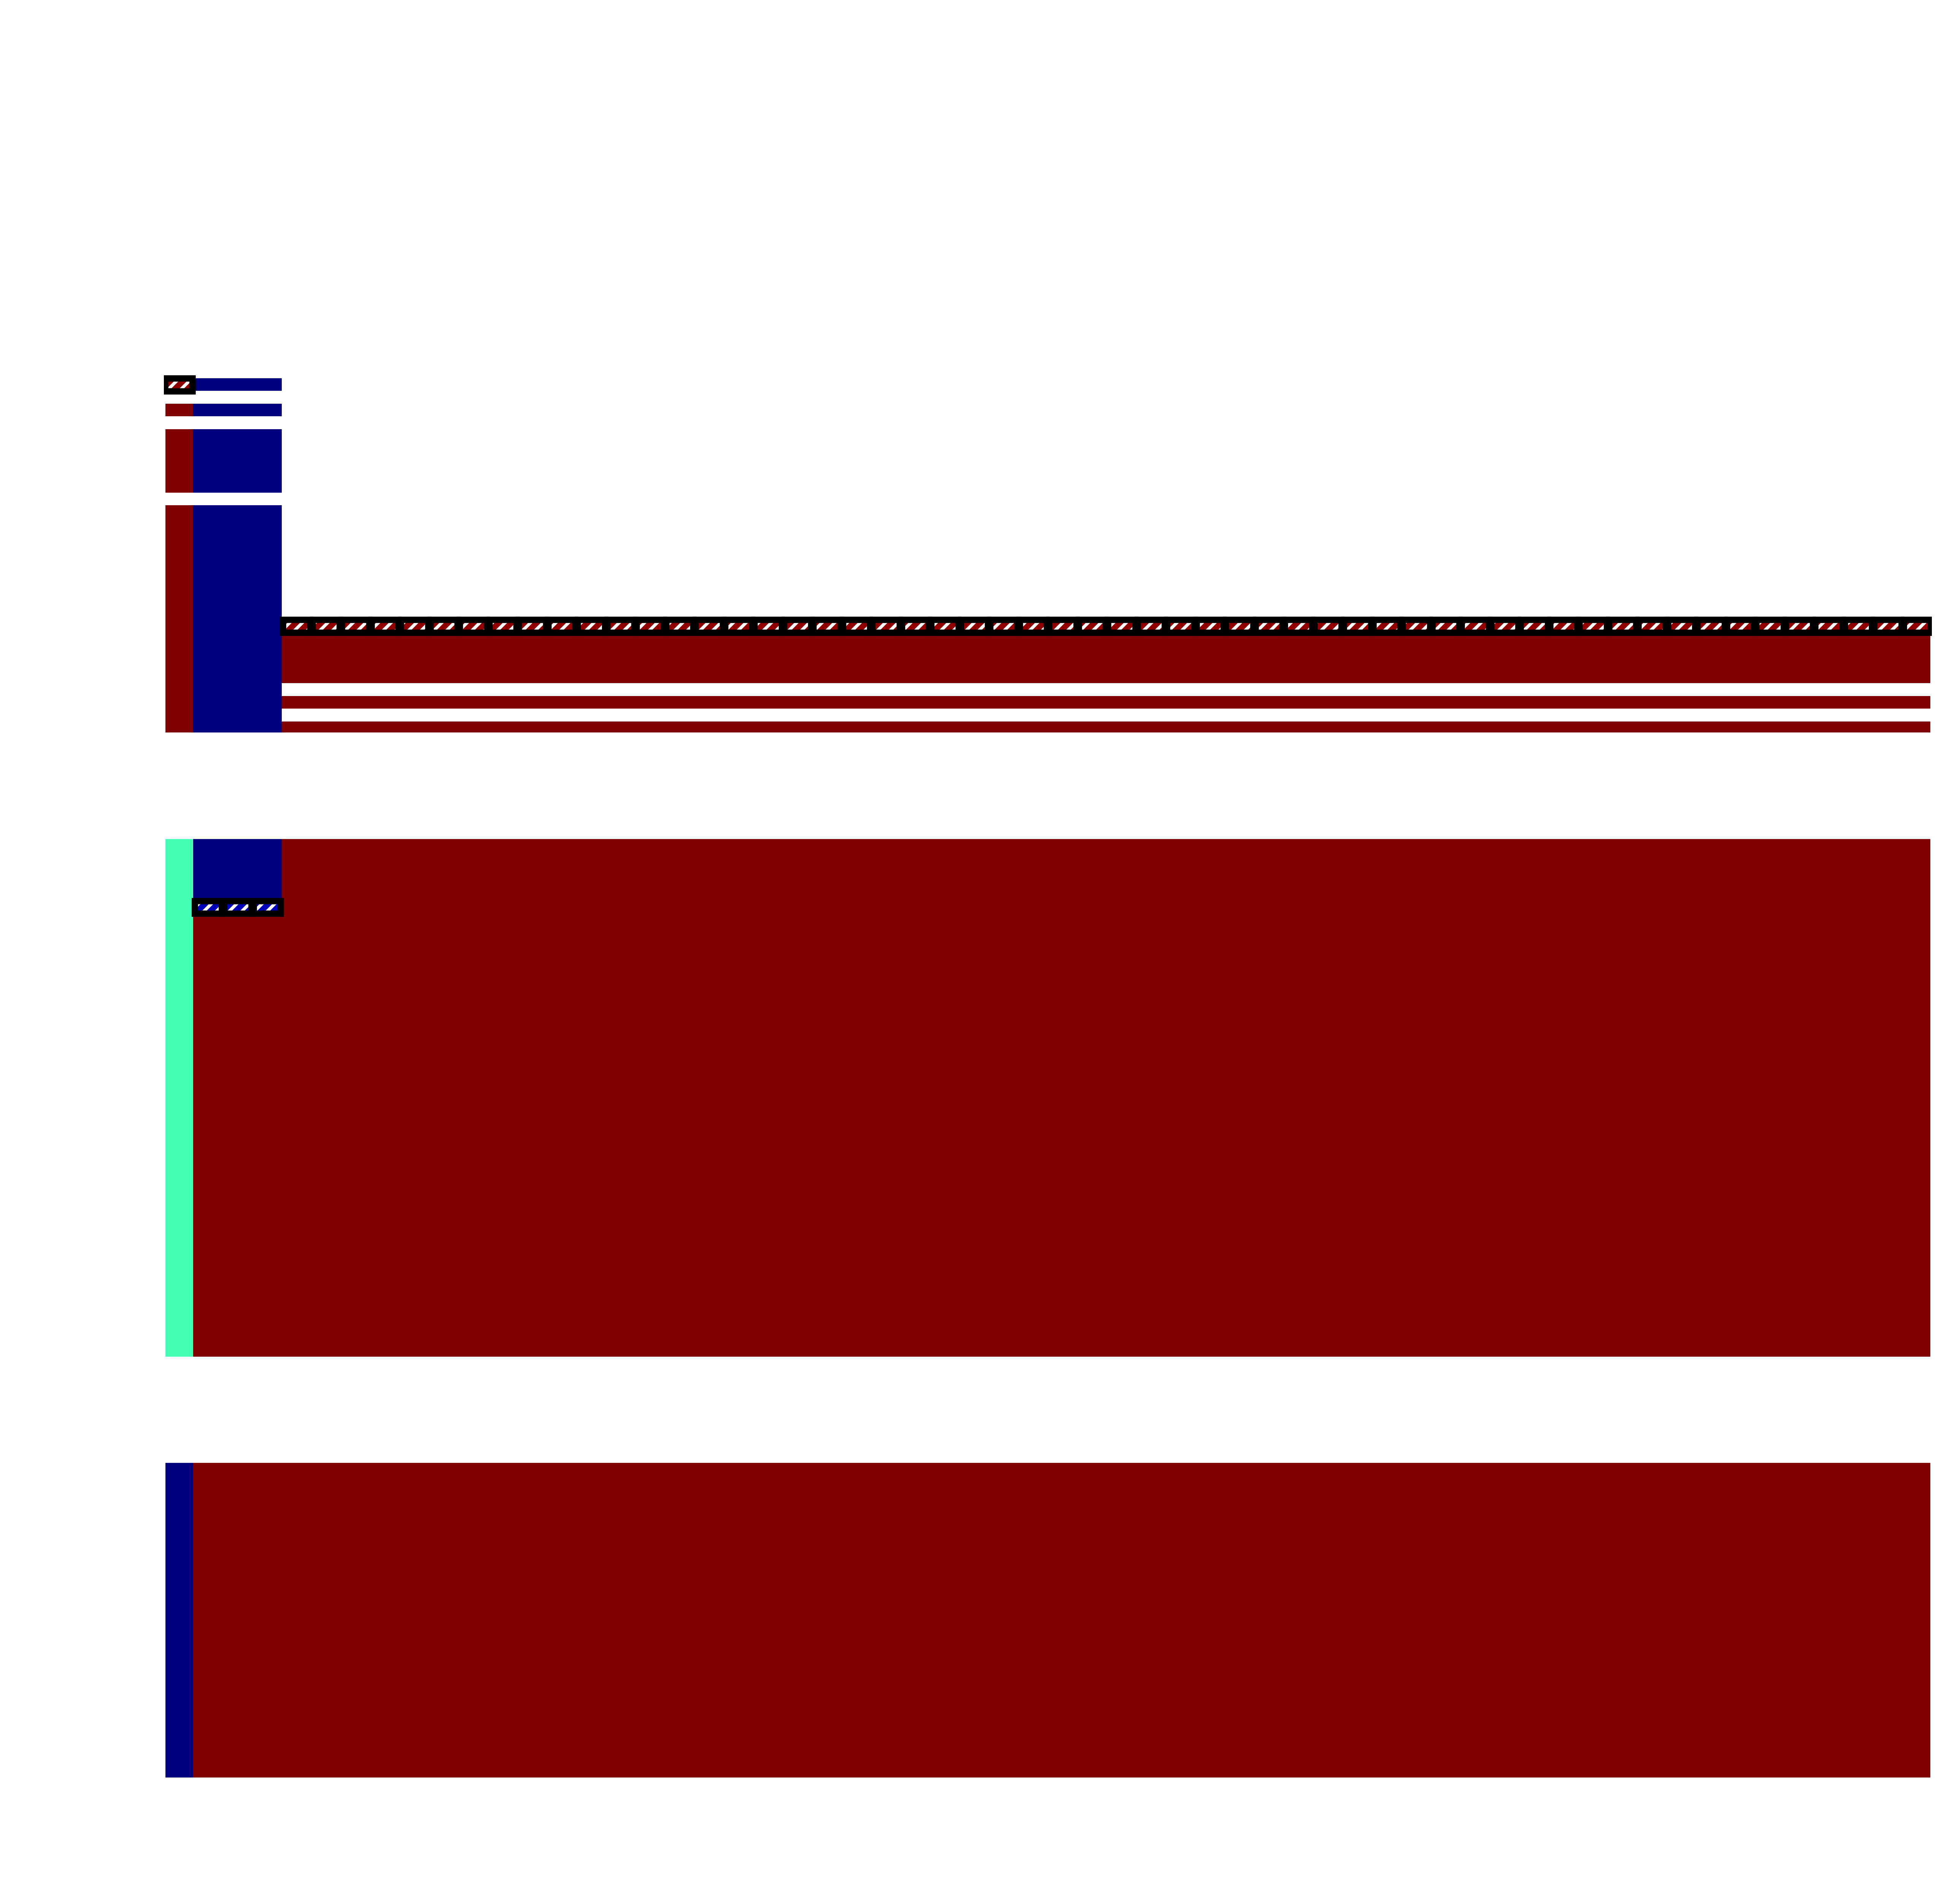

In [7]:
_ = plot_schedule_heatmap(input_uc=input_uc_ic, output_uc=output_uc_ic, is_prev=True, save_file_name="initial_condition")

**Q3 intiial conditions**

**commented out because i learned iw as wrong**

In [ ]:
# thermal_demand_scenarios = np.load(Path.cwd() /"data"/ "input" / "processed" / "thermal_demand_2022721_tk.npy")

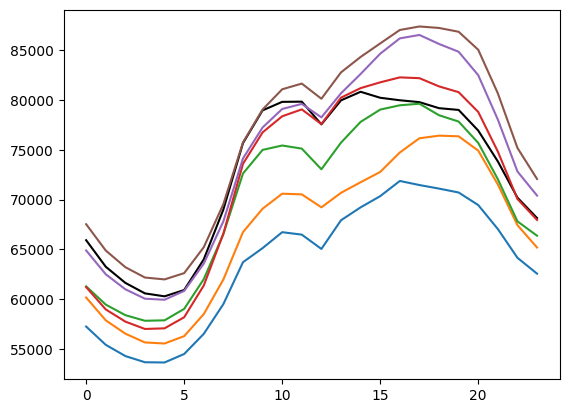

In [ ]:
# # ok i just decided to do this because the scenario range was actually so too much than i though
# # if i went on with the actual it wouldve distorted the Q3 results per scenario and the final result too.
# import matplotlib.pyplot as plt
# plt.plot(demand- renewable, c="black")
# plt.plot(thermal_demand_scenarios);

In [ ]:
# still no reserve margin this equally affects each scenario but really the reserve computed will
# be larger for the blue lines above but i guess i hit my limit here
# but rn with some fixes like adding k  scenario dimension to the prev data we can acehive this 
# u_prev will be tricky but anyways
# i need to thikn ahead the p_tight_minus proof and u minus proof too

In [ ]:
# p_prev.shape, u_prev.shape, min_up_r.shape, min_down_r.shape, min_up_0.shape, min_down_0.shape

((122,), (122, 48), (122,), (122,), (122,), (122,))

In [ ]:
# def get_initial_conditions_per_scenarios(thermal_demand_scenarios_k, reserve_margin_ic: float, verbose: bool):
#     num_periods_ic = 60
#     # pure black start prev condition
#     p_prev_ic = np.zeros(num_units)
#     u_prev_ic = np.zeros((num_units, num_periods_ic), dtype=np.int64)
#     min_up_r_ic, min_down_r_ic, min_up_0_ic, min_down_0_ic = get_min_up_down_initials(num_units, min_up, min_down, u_prev_ic)

#     thermal_demand_scenarios_k_ic = np.full((num_periods_ic), thermal_demand_scenarios_k[0])
#     renewable_ic = np.full((num_periods_ic), 0) # renewable already accounted so we just set 0
#     reserve_ic = (thermal_demand_scenarios_k_ic) * reserve_margin_ic # idk why im keeping this but idk maybe 

#     input_uc_ic = Input_uc(
#         # meta
#         unit_type=unit_type,
#         idx_nuclear=idx_nuclear,
#         idx_coal=idx_coal,
#         idx_lng=idx_lng,
#         num_units=num_units,
#         num_periods=num_periods_ic,
#         # system
#         demand=thermal_demand_scenarios_k_ic,
#         reserve=reserve_ic,
#         renewable=renewable_ic,
#         # generator
#         p_min=p_min,
#         p_max=p_max,
#         ramp_up=ramp_up,
#         ramp_down=ramp_down,
#         startup_ramp=startup_ramp,
#         shutdown_ramp=shutdown_ramp,
#         min_up=min_up,
#         min_down=min_down,
#         # cost function - generation
#         cost_lin=cost_lin,
#         cost_const=cost_const,
#         # cost function - startup (paper formulation)
#         cost_startup_step=cost_startup_step,
#         step_length=step_length,
#         # cost function - startup (lecture note formulation)
#         cost_startup_step_old=cost_startup_step_old,
#         num_cooling_steps_old=num_cooling_steps_old,
#         # initial conditions
#         p_prev=p_prev_ic,
#         u_prev=u_prev_ic,
#         min_up_r=min_up_r_ic,
#         min_down_r=min_down_r_ic,
#         min_up_0=min_up_0_ic,
#         min_down_0=min_down_0_ic,
#     )

#     output_uc_ic = Output_uc()
#     solve_uc(
#         input_uc=input_uc_ic, output_uc=output_uc_ic, verbose=verbose,
#     )
    

#     p_prev = output_uc_ic.p[:, -1]
#     u_prev = output_uc_ic.u[:, -48:]
#     min_up_r, min_down_r, min_up_0, min_down_0 = get_min_up_down_initials(num_units, min_up, min_down, u_prev)

#     return p_prev, u_prev, min_up_r, min_down_r, min_up_0, min_down_0, input_uc_ic, output_uc_ic

In [ ]:
# p_prev.shape, u_prev.shape, min_up_r.shape, min_down_r.shape, min_up_0.shape, min_down_0.shape

((122,), (122, 48), (122,), (122,), (122,), (122,))

In [ ]:
# num_scenarios = 6
# p_prev_scen = np.empty((num_units, num_scenarios))
# u_prev_scen = np.empty((num_units, 48, num_scenarios))
# min_up_r_scen = np.empty((num_units, num_scenarios))
# min_down_r_scen = np.empty((num_units, num_scenarios))
# min_up_0_scen = np.empty((num_units, num_scenarios))
# min_down_0_scen = np.empty((num_units, num_scenarios))

In [15]:
# thermal_demand_scenarios.shape
# # thermal_demand_scenarios[:, 0][]
# [thermal_demand_scenarios[:, k][0] for k in range(num_scenarios)]

In [ ]:
# input_uc_ic_scen = []
# output_uc_ic_scen = []
# for k in range(num_scenarios):
#     p_prev, u_prev, min_up_r, min_down_r, min_up_0, min_down_0,  input_uc_ic, output_uc_ic = get_initial_conditions_per_scenarios(
#         thermal_demand_scenarios_k = thermal_demand_scenarios[:, k],
#         reserve_margin_ic=0, verbose=True,
#     )

#     p_prev_scen[:, k] = p_prev
#     u_prev_scen[:, :, k] = u_prev
#     min_up_r_scen[:, k] = min_up_r
#     min_down_r_scen[:, k] = min_down_r
#     min_up_0_scen[:, k] = min_up_0
#     min_down_0_scen[:, k] = min_down_0
#     input_uc_ic_scen.append(input_uc_ic)
#     output_uc_ic_scen.append(output_uc_ic)

#     # i pray to god this is correct

Set parameter OutputFlag to value 1
Set parameter Symmetry to value 2
Set parameter PreDual to value 2
Set parameter Presolve to value 1
Set parameter PreSparsify to value 2
Set parameter Disconnected to value 2
Set parameter Heuristics to value 1
Set parameter ProjImpliedCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0
Set parameter IntFeasTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-09
IntFeasTol  1e-09
MIPGap  0
MIPGapAbs  0
OptimalityTol  1e-09
Disconnected  2
Heuristics  1
Symmetry  2
ProjImpliedCuts  2
PreDual  2
Presolve  1
PreSparsify  2

Optimize a model with 86574 rows, 58560 columns and 325792 nonzeros
Model 

In [ ]:
# p_prev_scen
# u_prev_scen
# min_up_r_scen
# min_down_r_scen
# min_up_0_scen
# min_down_0_scen;

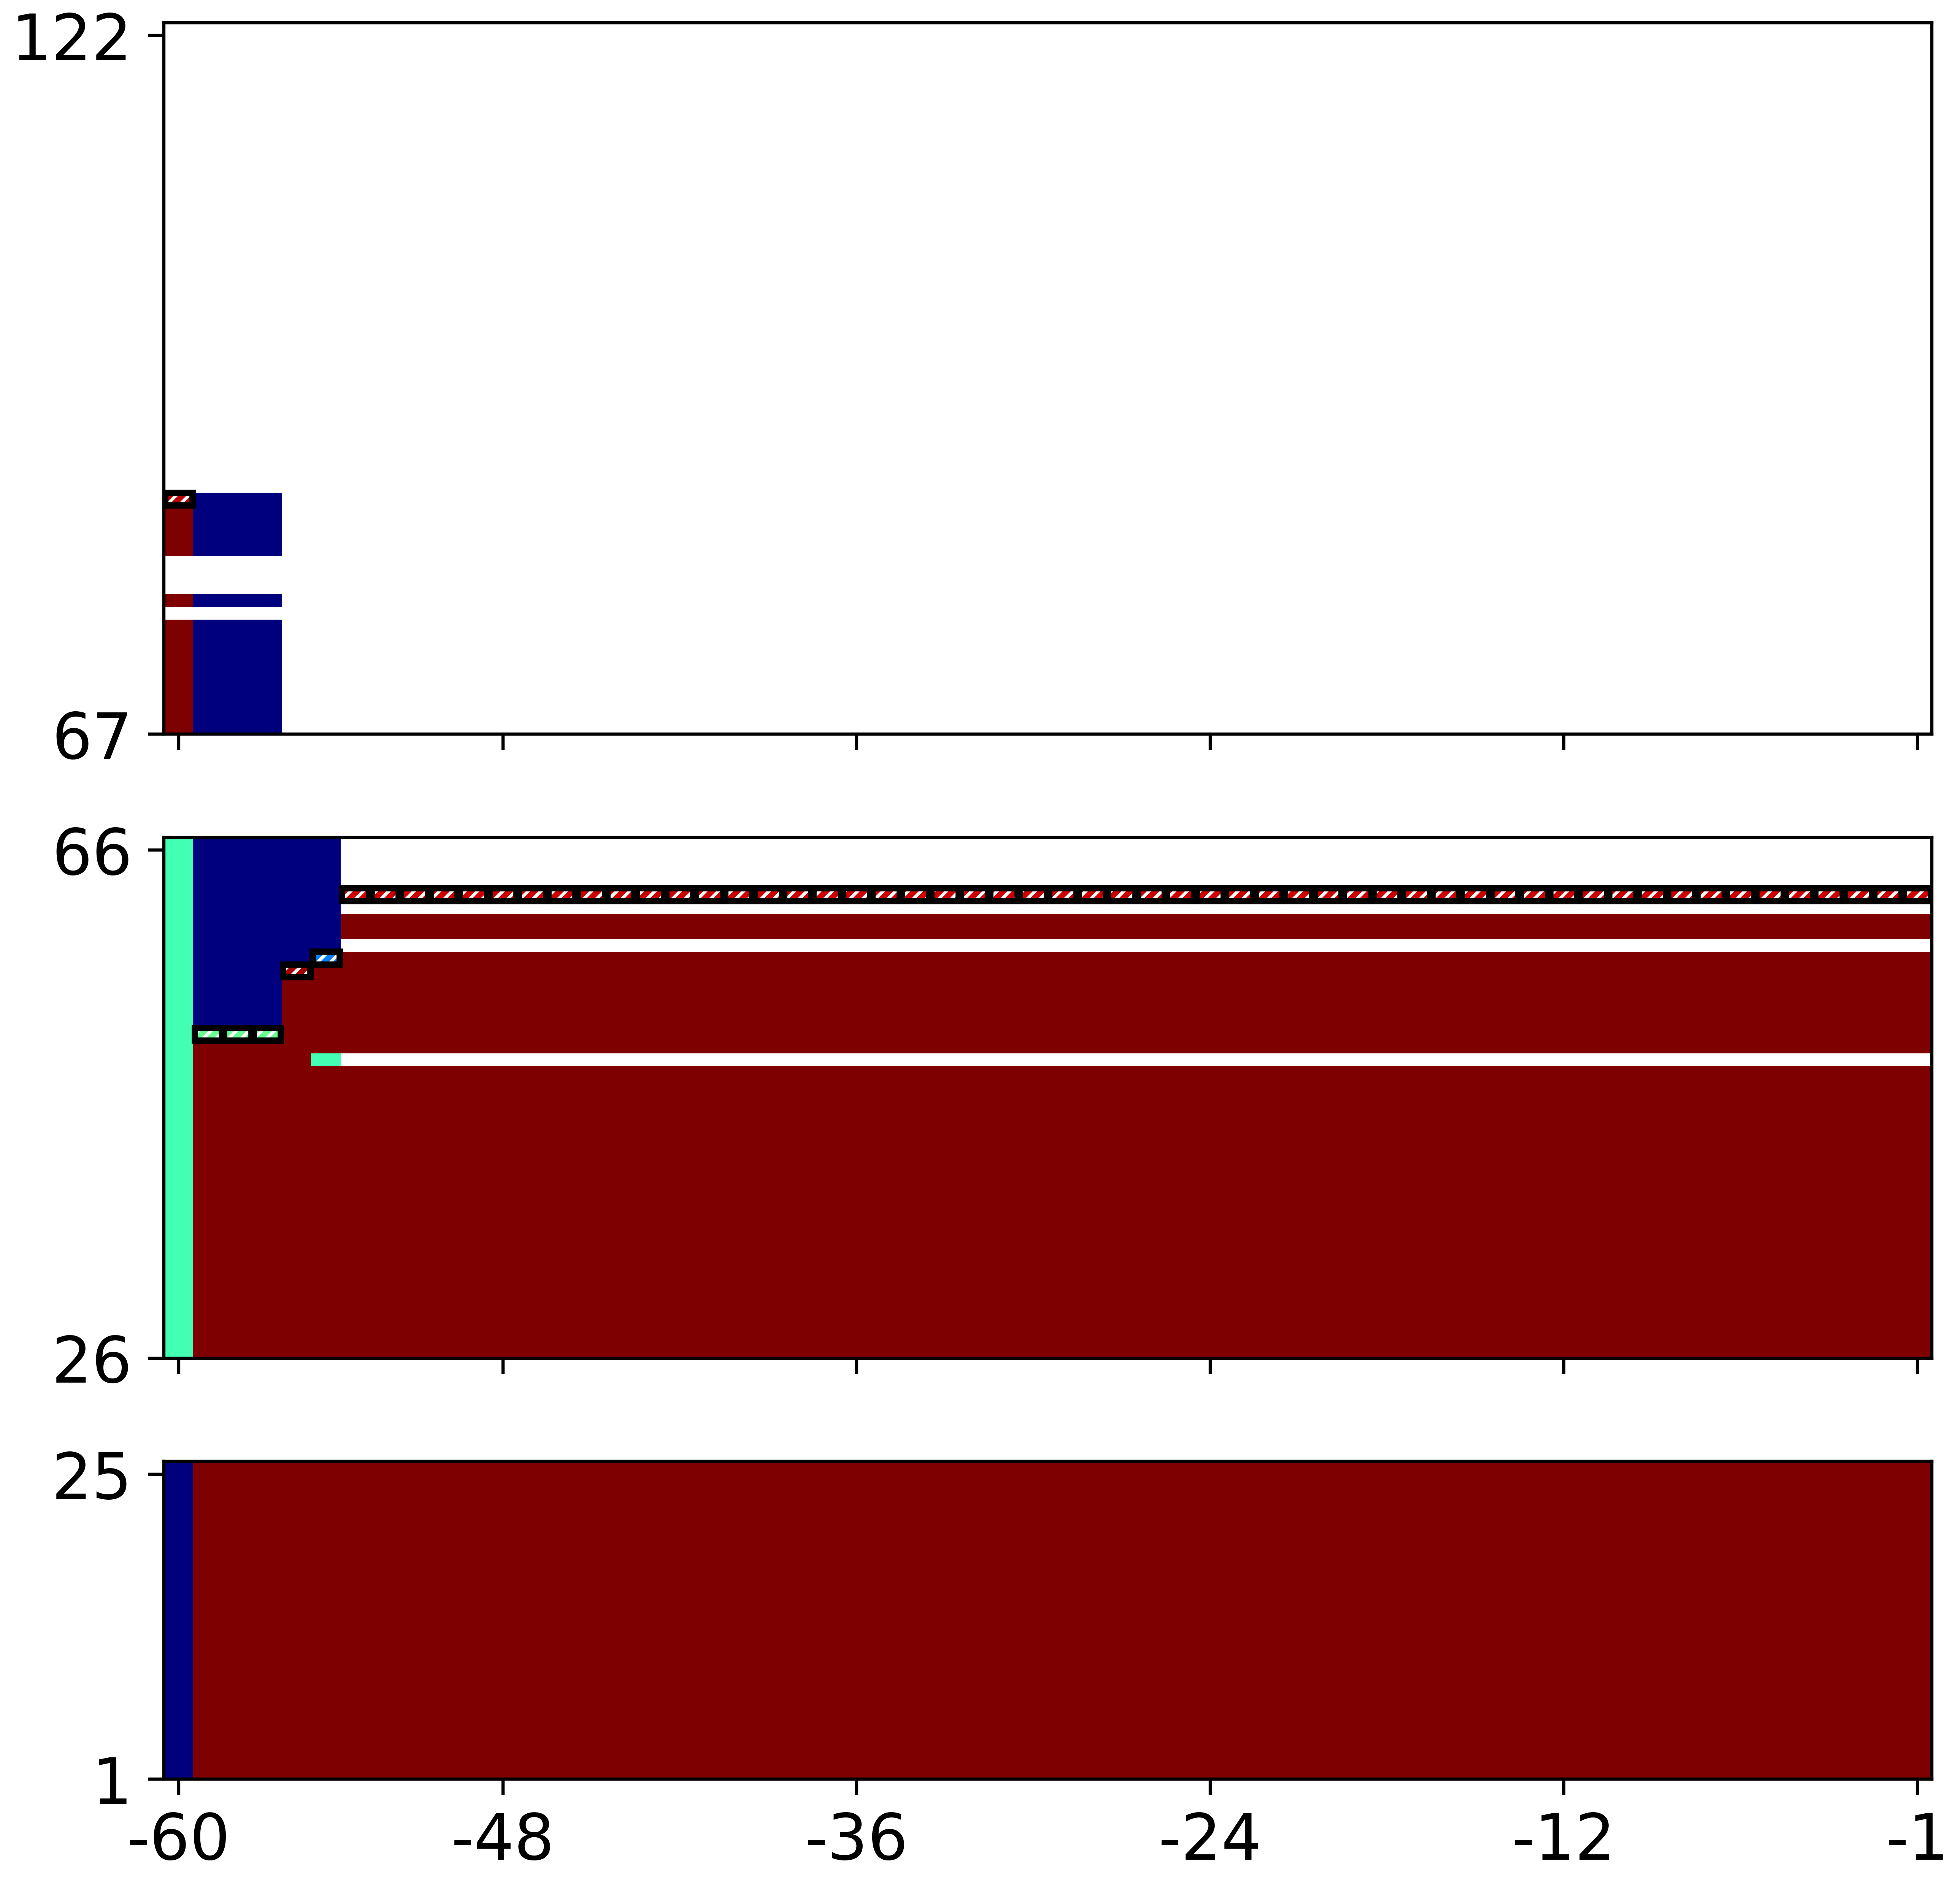

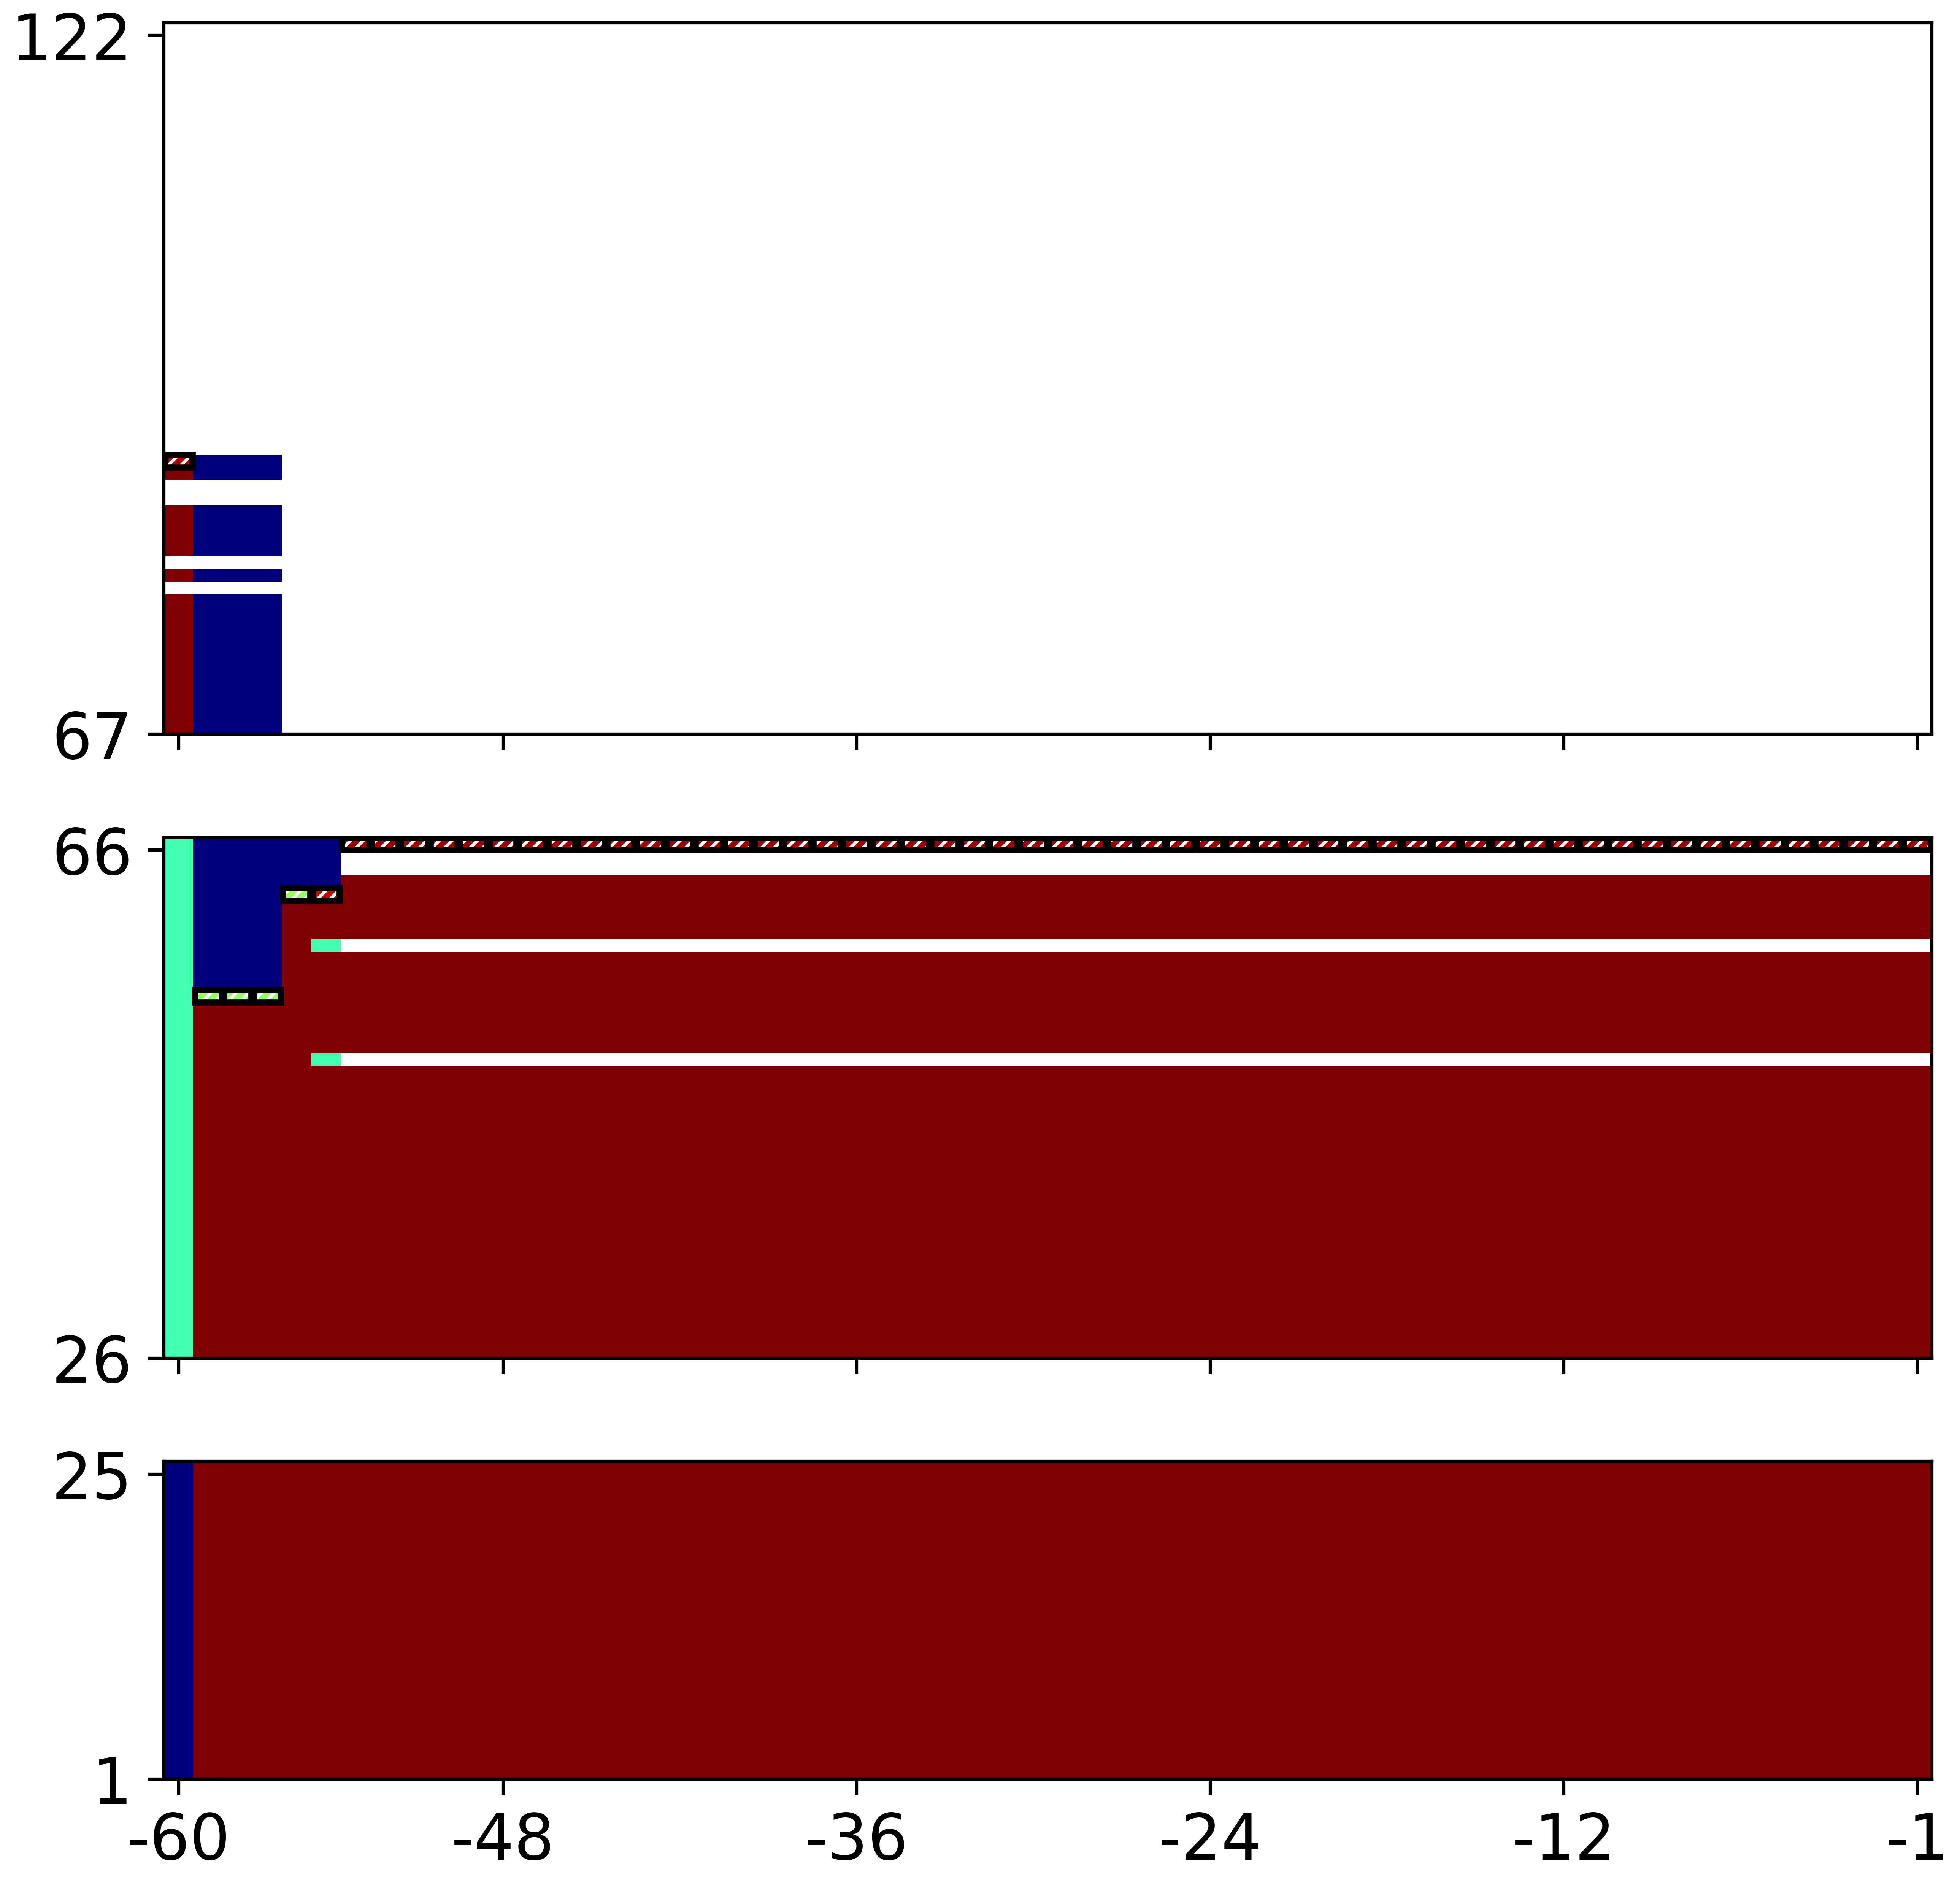

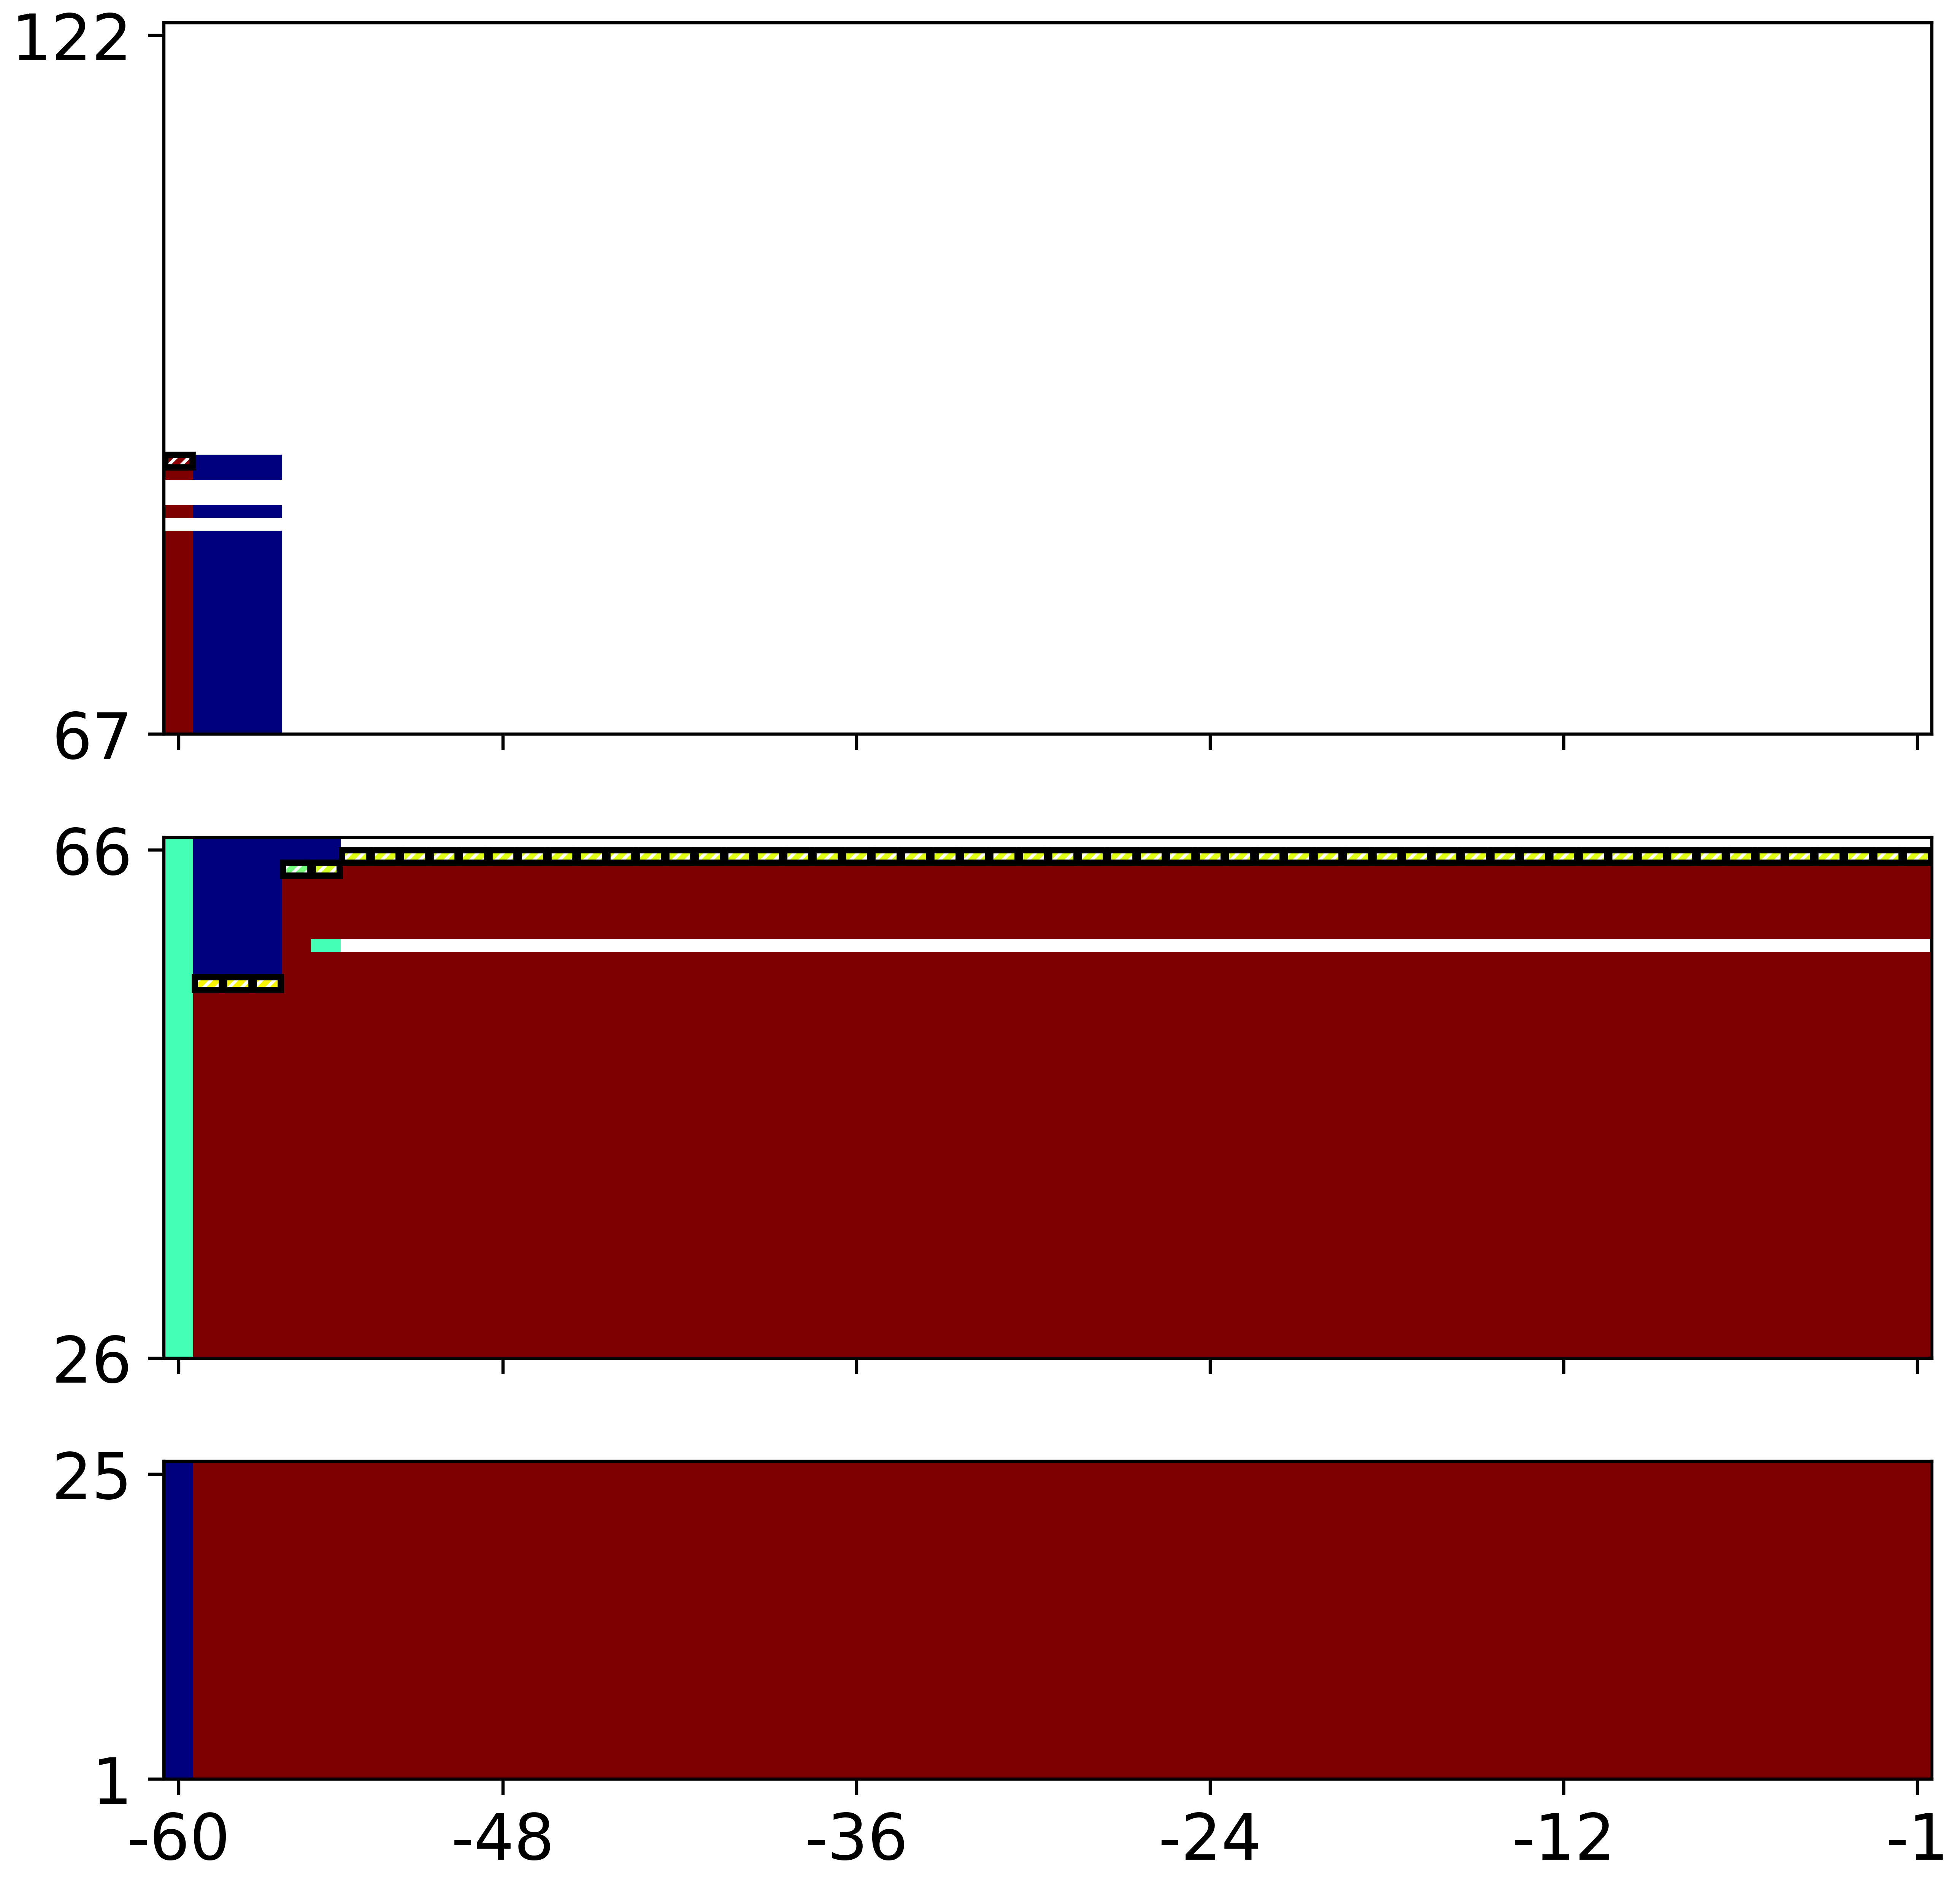

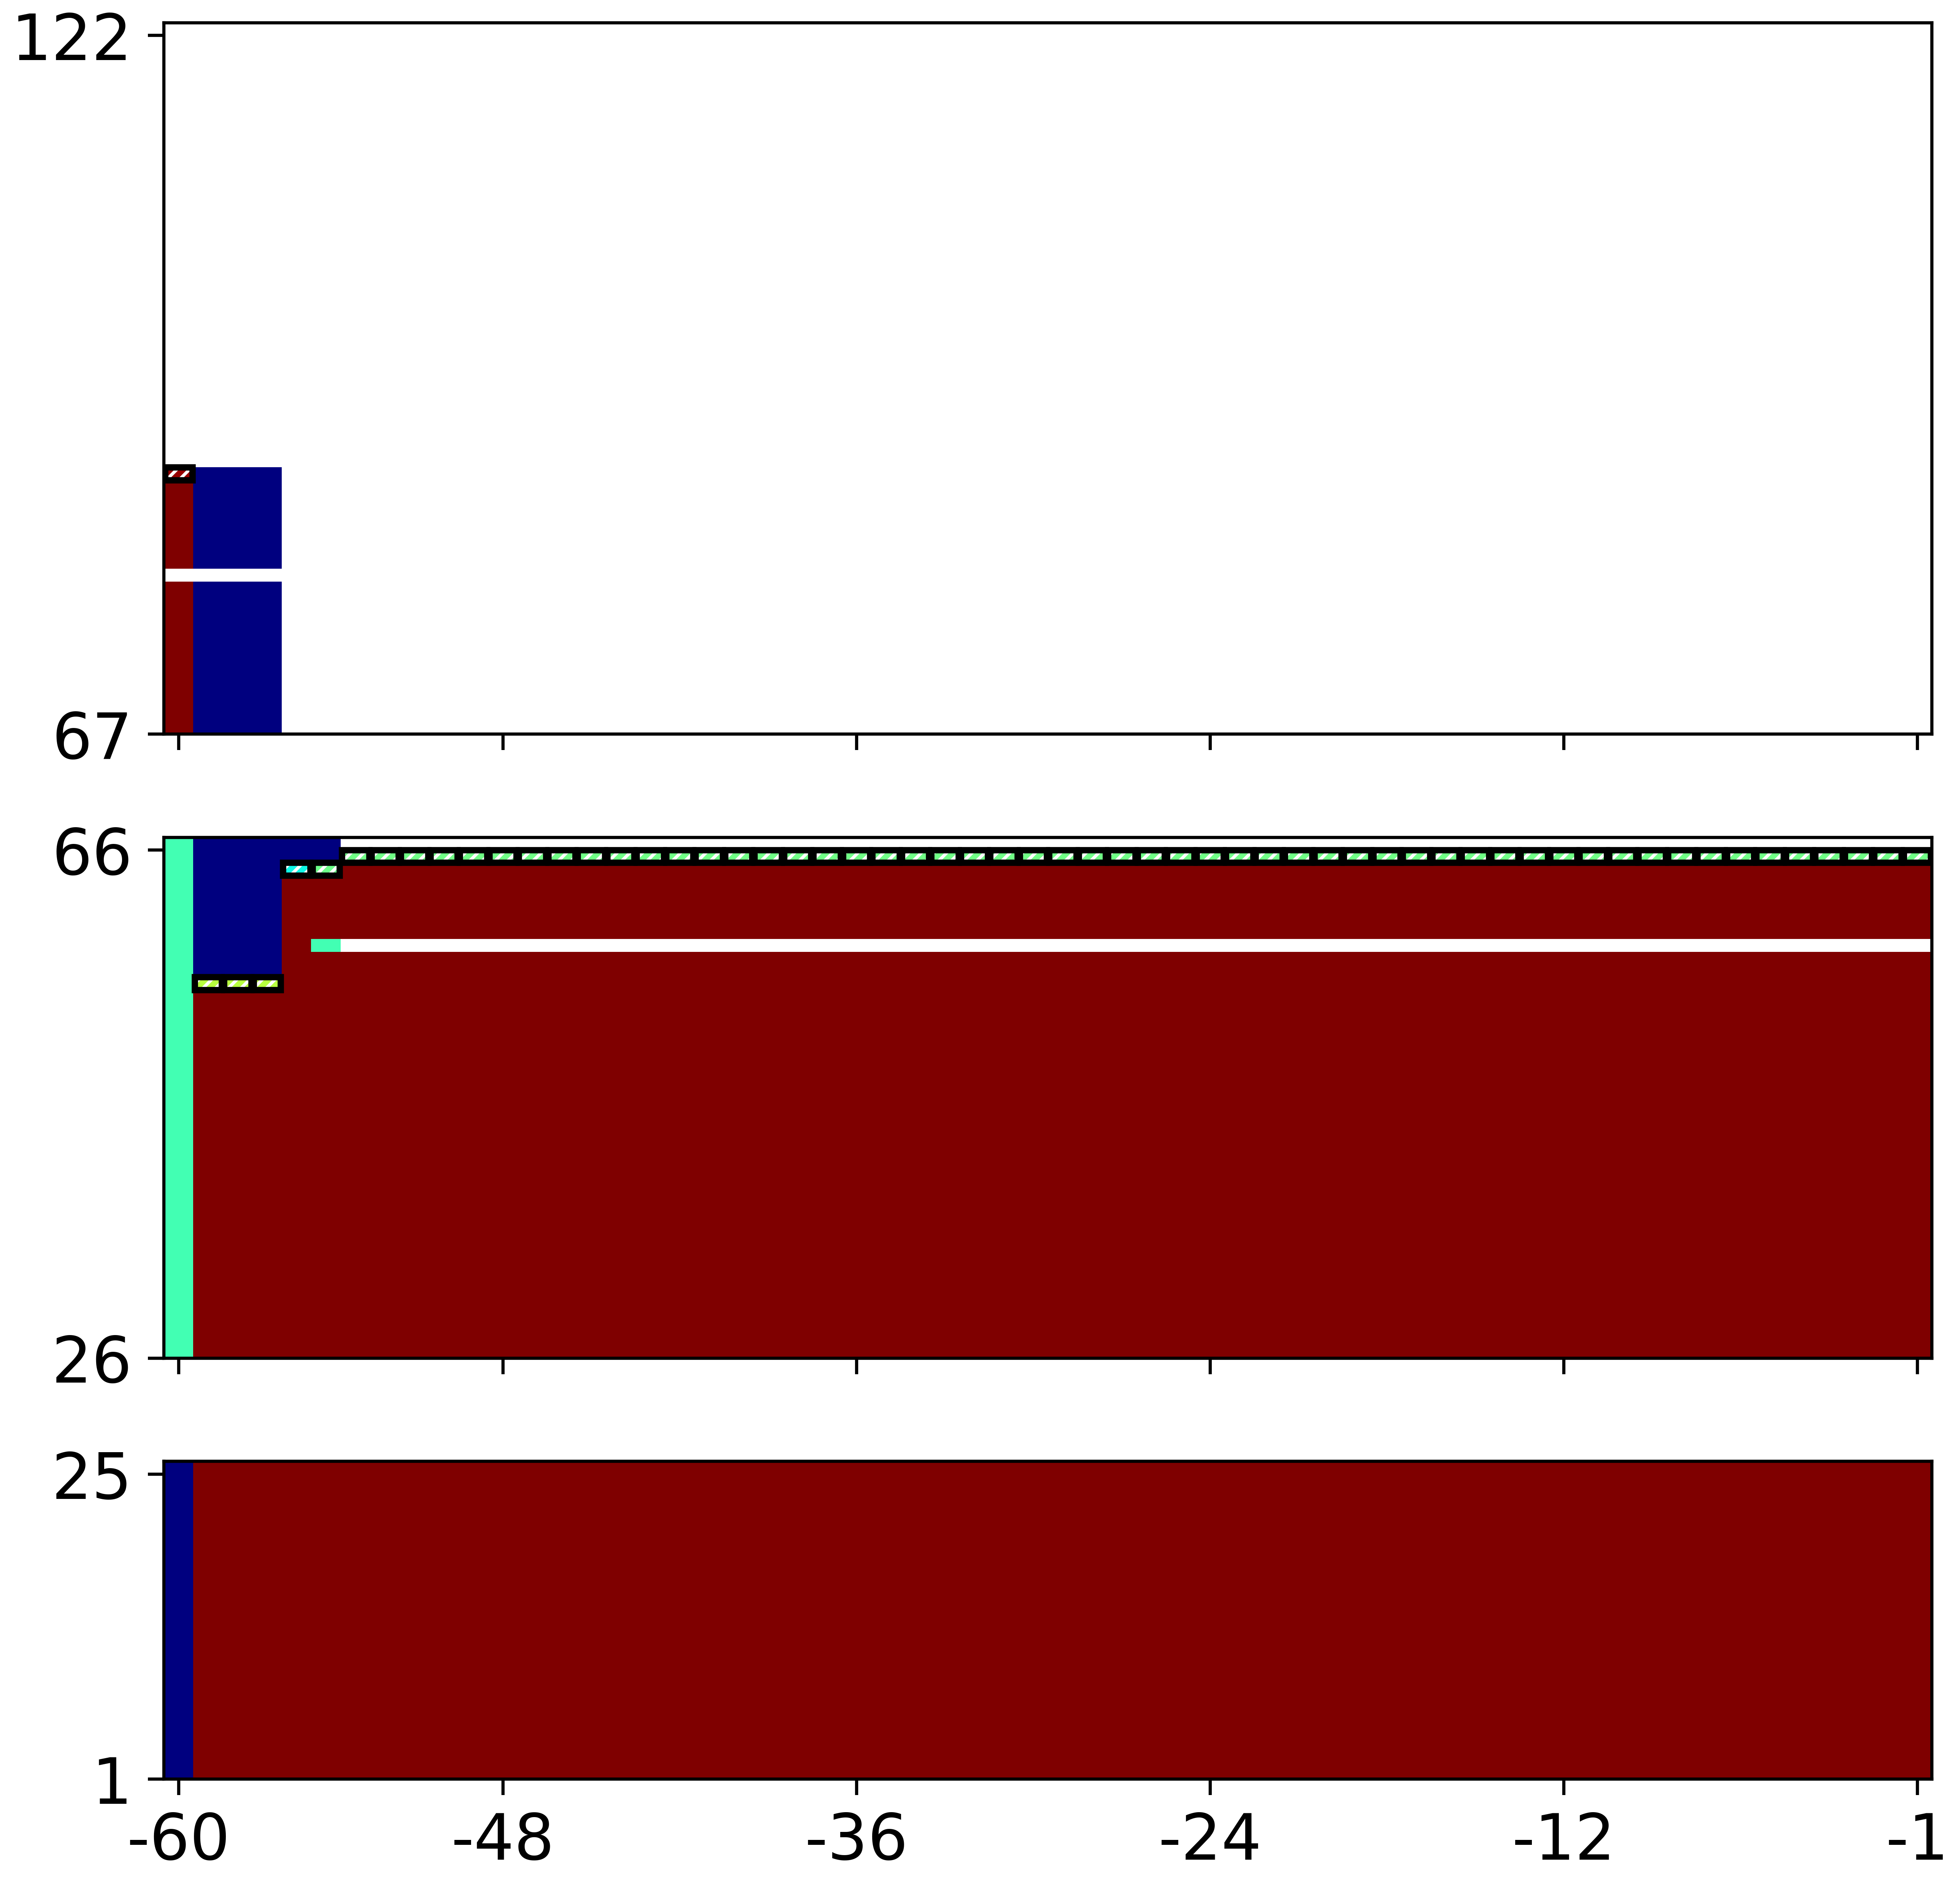

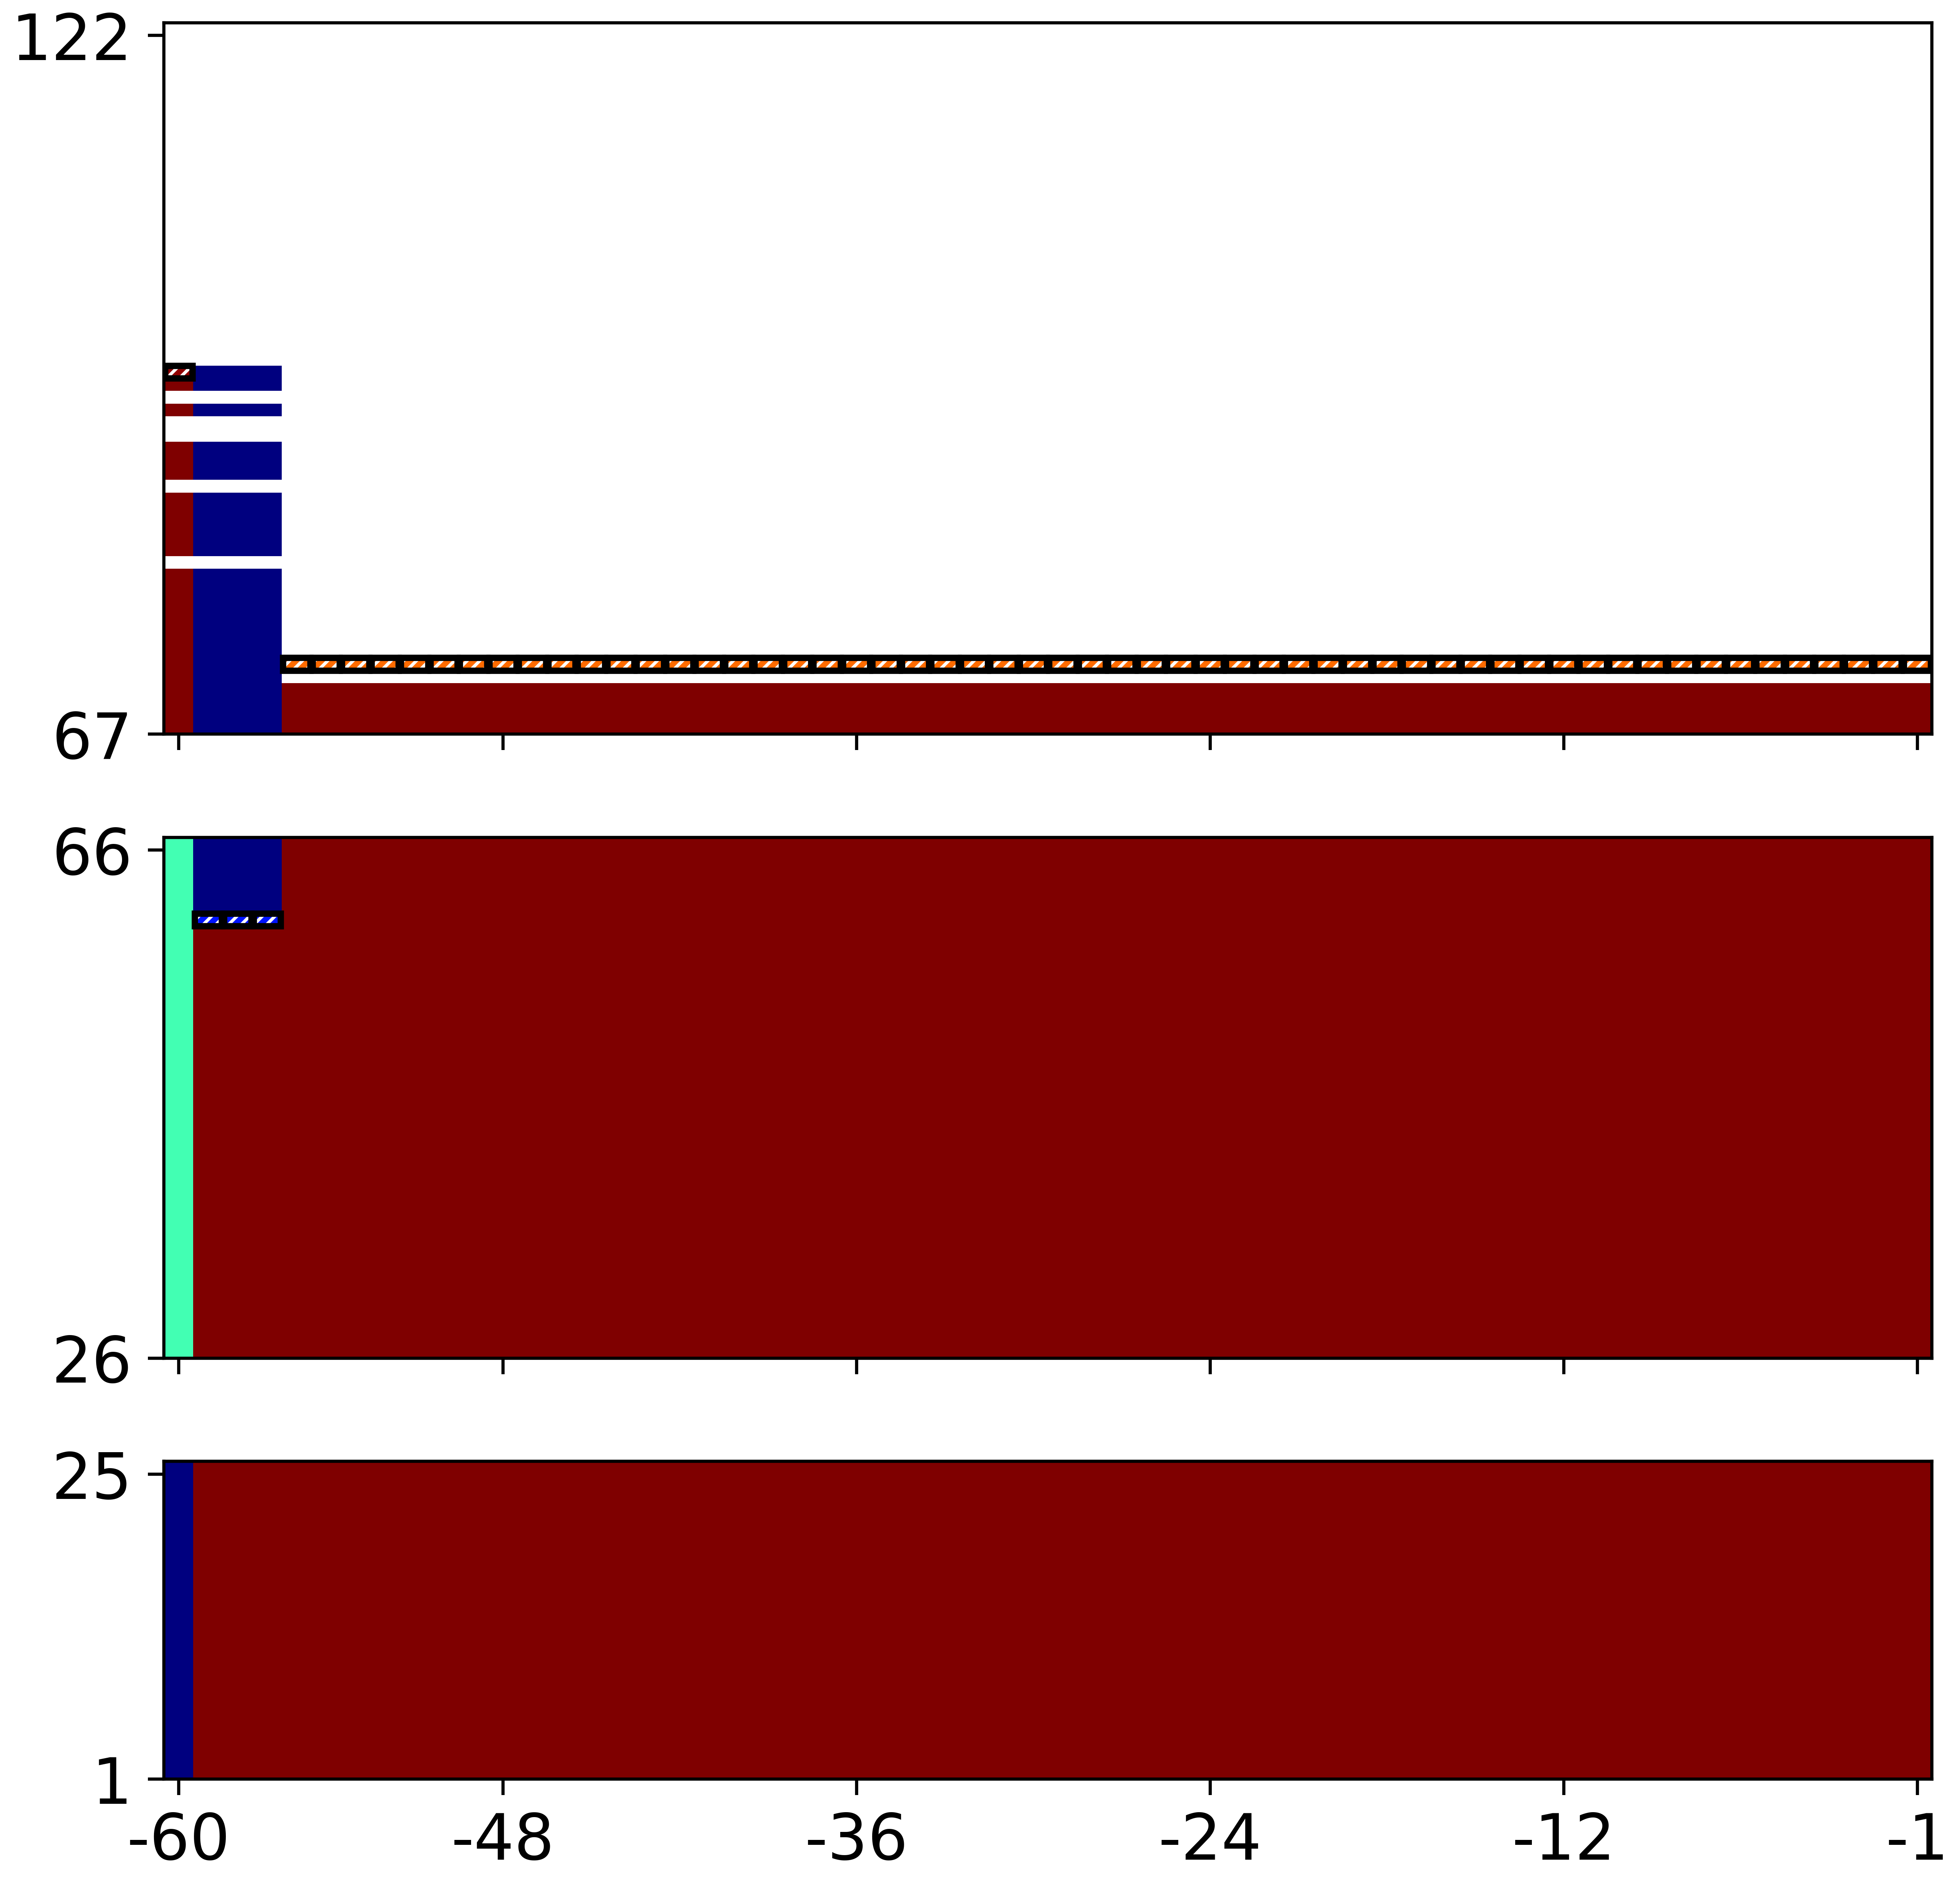

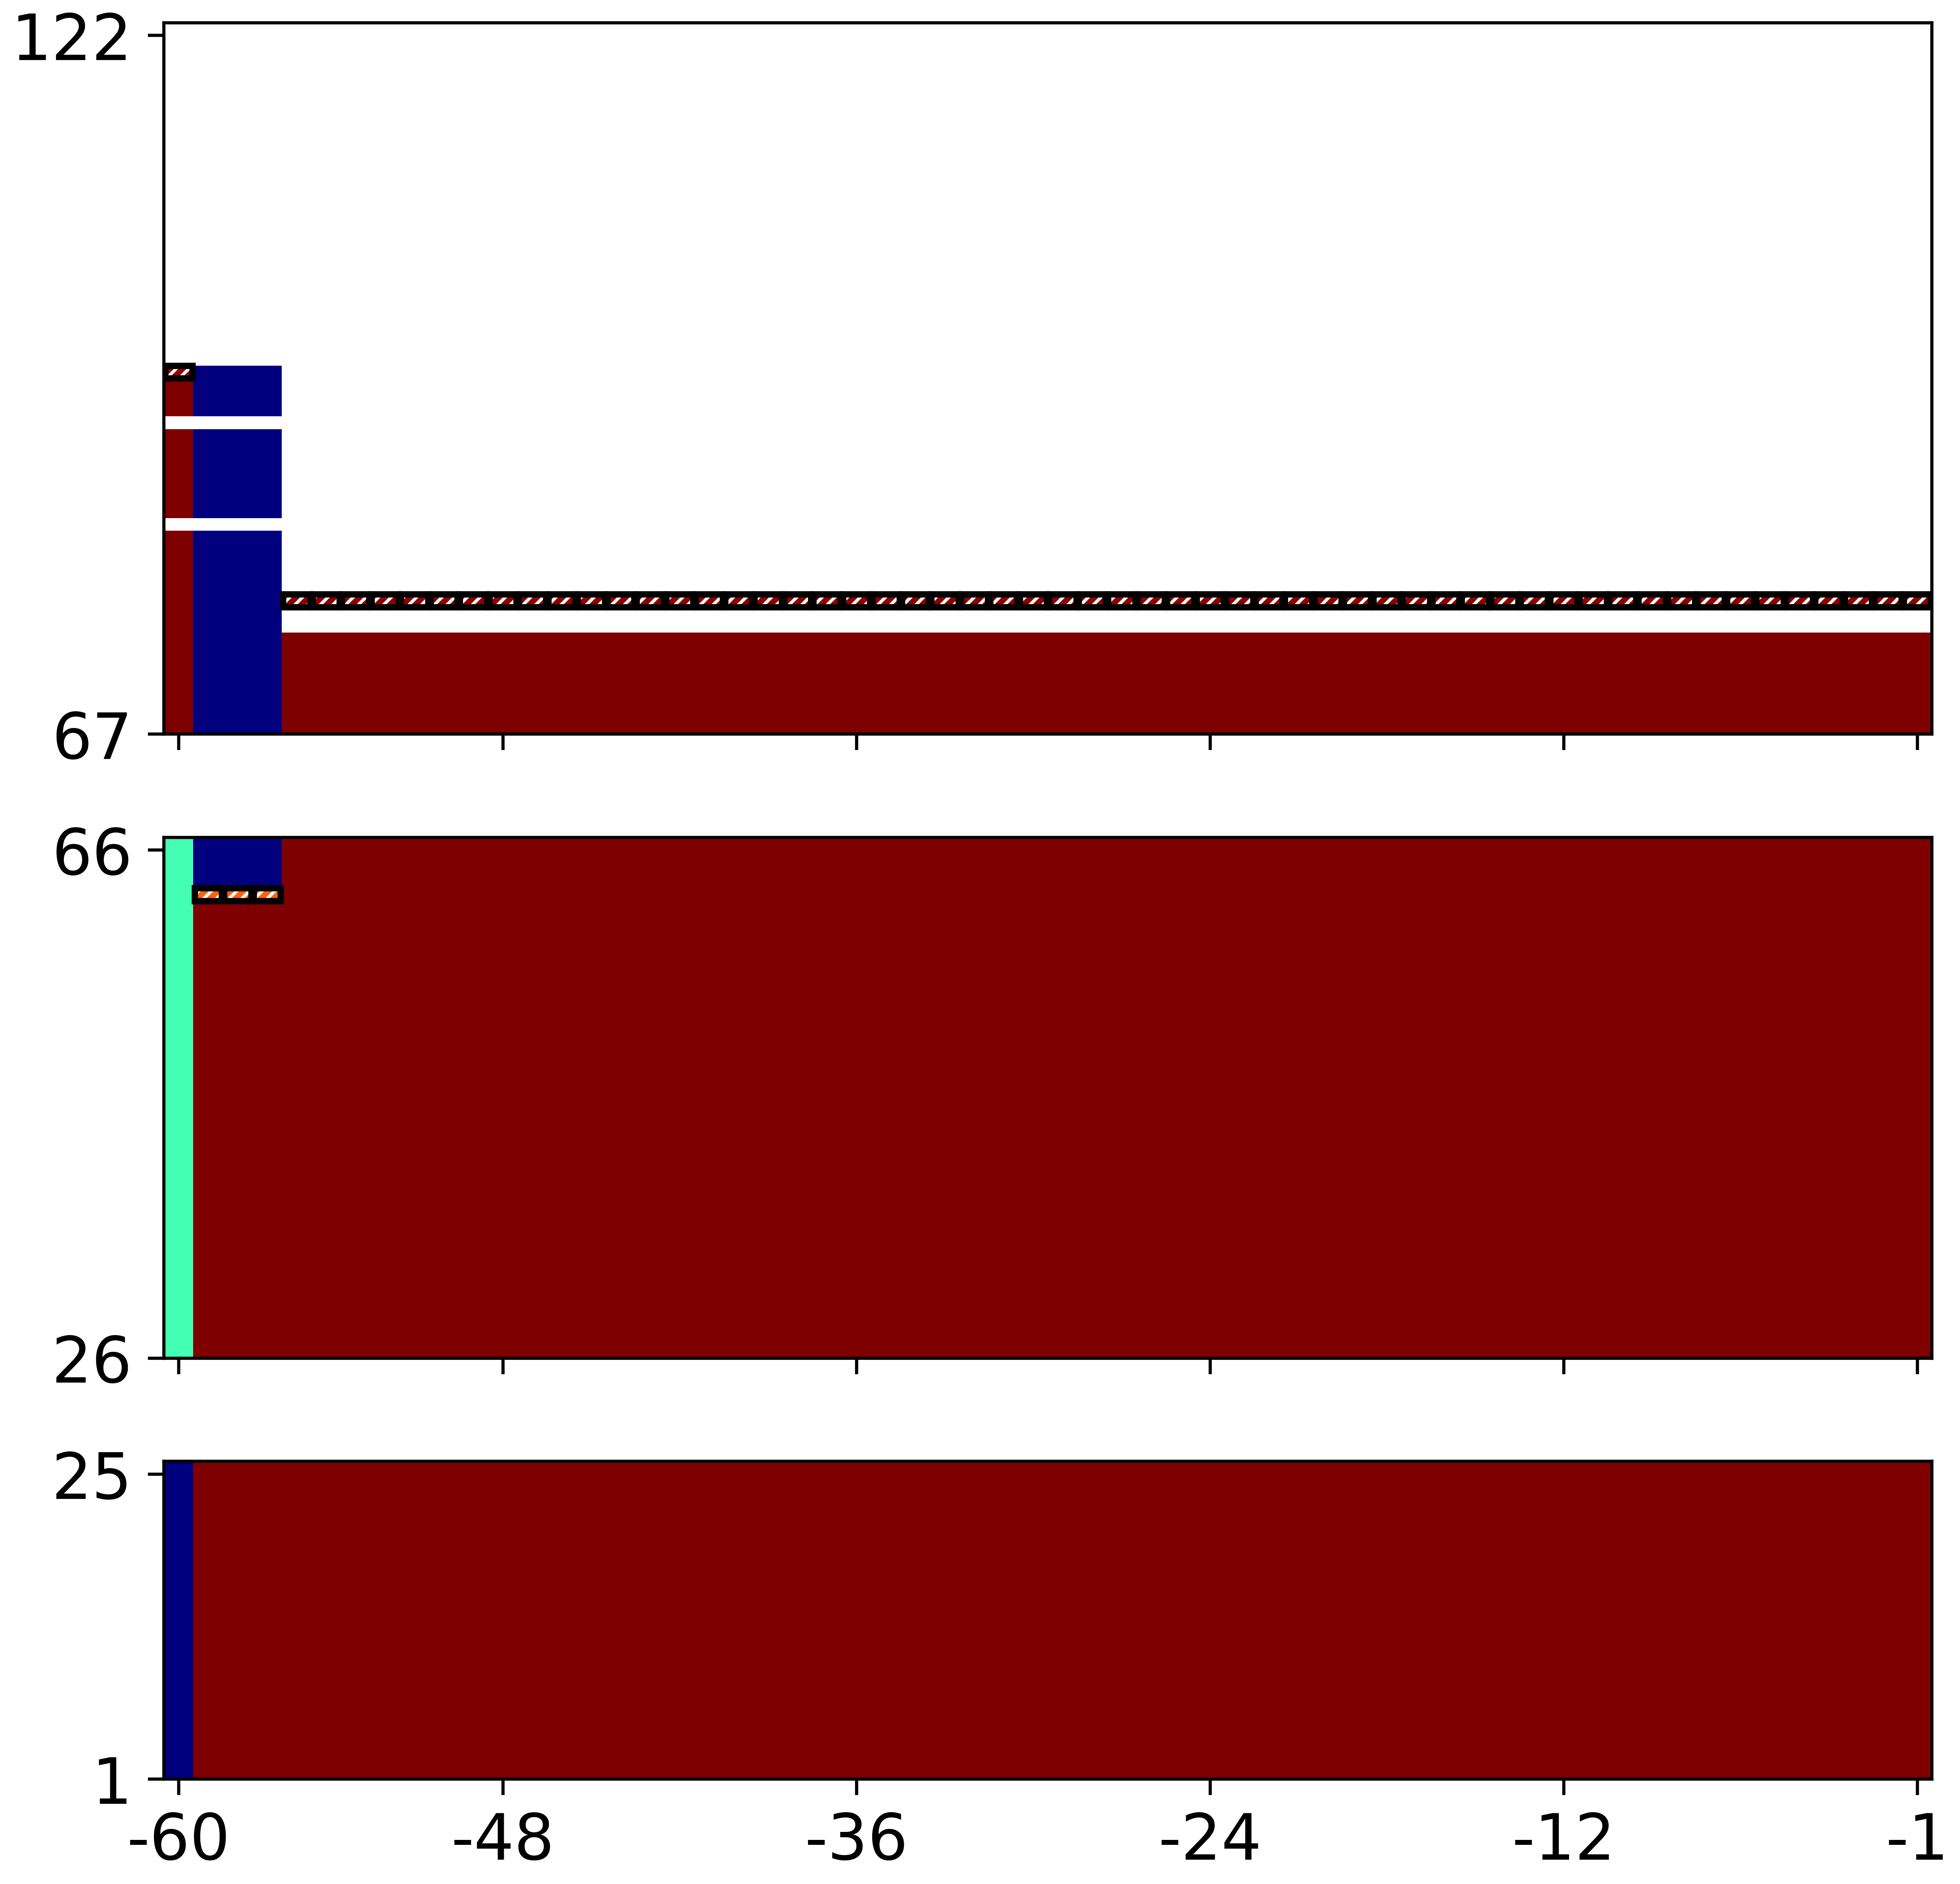

In [ ]:
# for k in range(num_scenarios):
#     _ = plot_schedule_heatmap(input_uc=input_uc_ic_scen[k], output_uc=output_uc_ic_scen[k], is_prev=True, do_white=False, save_file_name="initial_condition")

In [ ]:
# # looks good and its still better than just one initial conditions for different scenarios with different thermal demand 
# # far better good imporvemnet
# path_folder_processed = Path.cwd() / "data" / "input" / "processed"

# np.save(path_folder_processed / "p_prev_scen.npy", p_prev_scen)
# np.save(path_folder_processed / "u_prev_scen.npy", u_prev_scen)
# np.save(path_folder_processed / "min_up_r_scen.npy", min_up_r_scen)
# np.save(path_folder_processed / "min_down_r_scen.npy", min_down_r_scen)
# np.save(path_folder_processed / "min_up_0_scen.npy", min_up_0_scen)
# np.save(path_folder_processed / "min_down_0_scen.npy", min_down_0_scen)